# Fashion Item Recognition
***
## Table of Contents

In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

## 1. Introduction

Image recognition is a fundamental and powerful technique in the field of deep learning, renowned for its versatility across a wide range of applications in computer vision.

This project aims to apply convolutional neural networks (CNNs) architectures and implement foundational deep learning models capable of identifying and classifying images of clothing items contained in the Fashion MNIST dataset. Through this work, key aspects of model architecture, training dynamics, and evaluation metrics are explored, serving as an introduction to practical image recognition with neural networks.

## 2. Loading Data

In [2]:
train_data = datasets.FashionMNIST(
    root="_datasets",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)
test_data = datasets.FashionMNIST(
    root="_datasets", train=False, download=True, transform=ToTensor()
)

## 3. Understanding Data

In [3]:
print(
    f"Data size \n X_train: {len(train_data.data)}, X_test: {len(test_data.data)}\n y_train: {len(train_data.targets)}, y_test: {len(test_data.targets)}"
)

Data size 
 X_train: 60000, X_test: 10000
 y_train: 60000, y_test: 10000


In [4]:
image, label = train_data[0]

In [5]:
image.shape

torch.Size([1, 28, 28])

The shape of the image tensor `[1, 28, 28]`  refers to `[colour channel, height, width]`. Having only one colour channel indicates that the image is grayscale, whereas having three colour scales implies a colourful image based on the red, green and blue (RGB model).

In [6]:
label

9

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

The Fashion MNIST dataset contains 10 different types of clothing with an equal number of samples in each class.

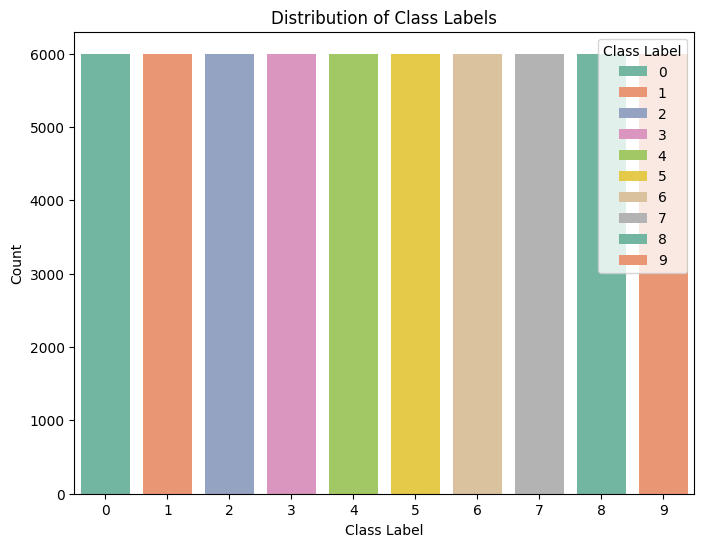

In [8]:
targets = train_data.targets.numpy()
unique_vals, counts = np.unique(targets, return_counts=True)
df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})

plt.figure(figsize=(8, 6))
sns.barplot(data=df_dist, x="Class Label", y="Count", hue="Class Label", palette="Set2")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Class Labels")
plt.show()


Image Shape: torch.Size([1, 28, 28])


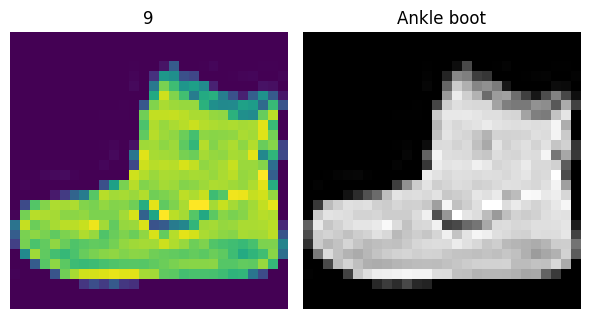

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 9))
axes[0].imshow(image.squeeze())
axes[0].set_title(label)
axes[1].imshow(image.squeeze(), cmap="gray")
axes[1].set_title(class_names[label])

print(f"Image Shape: {image.shape}")
axes[0].axis(False)
axes[1].axis(False)
plt.tight_layout()
plt.show()

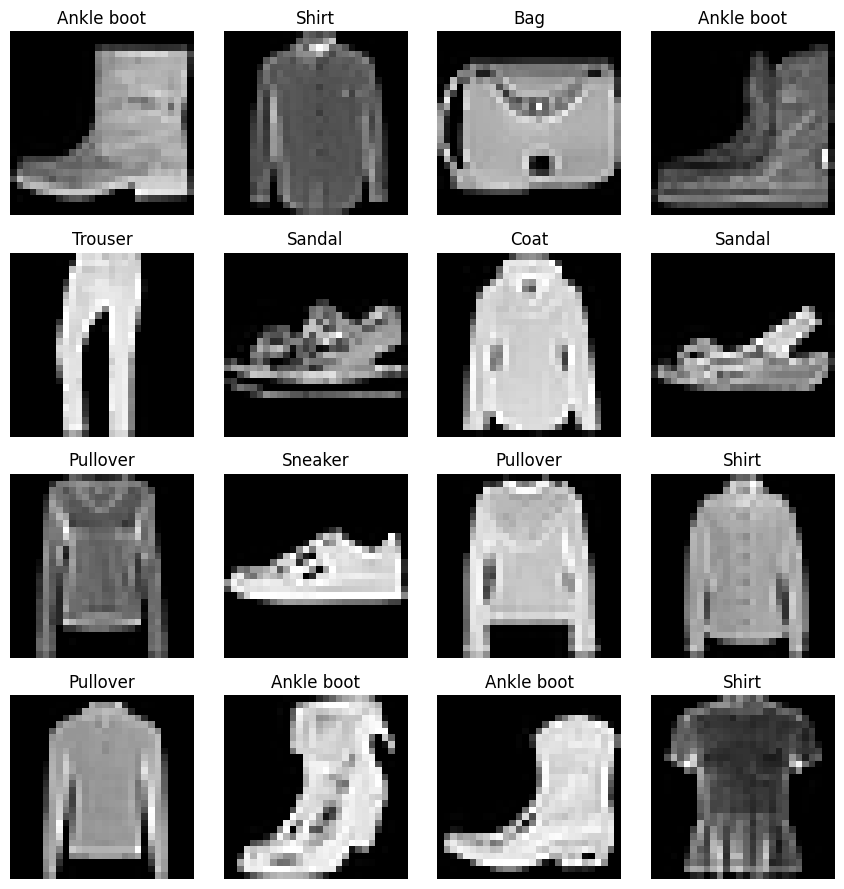

In [10]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(low=0, high=len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
    plt.tight_layout()
plt.show()

## 4. Prepare DataLoader
`torch.utils.data.DataLoader()` increases the computational efficiency by dividing a large dataset into smaller chunks (called **batches** or **mini-batches**). The size of these batches is controlled by the hyperparameter `batch_size`. Processing data in batches allows gradient descent to be performed once per batch rather than once per epoch, facilitating faster and more stable training process. 

By setting `shuffle=True`, the order of the samples is randomised to promote effective learning and reduce bias of the model. Shuffling should be enabled only for training data, not for test data to ensure reproducible and unbiased evaluation.

Typically, the value of the hyperparameter `batch_size` is set as a power of 2 (32, 64, 128, etc.). For example, with `batch_size = 32`, the `train_data` (60000 samples) will be converted to a `train_dataloader` (60000 // 32 = 1875 samples per batch), and the `test_data` (10000 samples) will be converted to a `test_dataloader` (10000 // 32 = 313 samples per batch).

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Length of train_dataloader: 1875
Length of test_dataloader: 313


In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Convolutional Neural Network (CNN) Architectures

In PyTorch, every class inheriting from `nn.Module` must call the `__init__` method of its parent with `super().__init__()` as the first step in the constructor (`__init__`). This ensures that the base class is properly set up before adding any submodules or layers.

The parameters are set as follows:

- `input_shape = 1`: Number of channels ($1$ for grayscale, $3$ for RGB)..
- `hidden_units = 20`: Number of units/neurons in the hidden layer(s), which can be any arbitrary positive number.
- `output_shape = len(class_names)`: Number of possible classes as an output.

In [13]:
class CNN(nn.Module):
    def __init__(
        self,
        input_shape: int,
        hidden_units: int,
        output_shape: int,
    ):
        super(CNN, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
torch.manual_seed(42)

model_cnn = CNN(
    input_shape=1,  # Number of colour channel
    hidden_units=10,  # Neurons in the hidden layer
    output_shape=len(class_names),  # Number of classes in target
)

In [15]:
from torchmetrics import Accuracy

calculate_accuracy = Accuracy(task="multiclass", num_classes=len(class_names))

loss_function = nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(params=model_cnn.parameters(), lr=0.1)

## Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss per batch.
1. For each epoch, iterate through testing batches, perform testing steps, calculate the test loss per batch.
1. Store the results.

### **Training Steps**:
1. Forward Pass
    - Pass inputs through the model to obtain predictions.
1. Calculate Loss Per Batch
    - Measure how far the predictions deviate from the true labels, using a loss function.
1. Zero the Gradients
    - Clear the previously stored gradients to prevent accumulation from multiple backward passes.
1. Backward Pass
    - Computes gradients of the loss with respect to the model's parameters via backpropagation.
1. Optimiser Step
    - Update the parameter $\theta$ using the gradients just computed, typically following an equation such as:
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average Training Loss
    - Computes the mean training loss across all batches for the epoch.

### **Testing Steps**:
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and desactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.
1. Calculate Loss Per Batch
    - Measure how far the predictions deviate from the true labels, using a loss function.
1. Update and Compute Accuracy
    - Updates accuracy state with each batch, and compute the overall accuracy after all test batches.
1. Average Test Loss
    - Computes the mean Test loss across all batches for the epoch.

In [16]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_function: torch.nn.Module,
    optimiser: torch.optim.Optimizer,
    calculate_accuracy,
):
    train_loss = 0
    calculate_accuracy.reset()
    for batch, (X, y) in enumerate(data_loader):
        model.train()
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss per batch
        loss = loss_function(y_pred, y)
        train_loss += loss.item()

        calculate_accuracy.update(y_pred, y)  # For torchmetrics, pass logits

        # 3. Optimiser zero grad
        optimiser.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimiser step
        optimiser.step()

        if batch % 500 == 0:
            print(f"{batch * len(X)} / {len(data_loader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(data_loader)
    train_acc = calculate_accuracy.compute().item() * 100  # Percentage
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_function: torch.nn.Module,
    calculate_accuracy,
):
    # ! Testing steps
    test_loss = 0
    calculate_accuracy.reset()  # Reset metric at start of evaluation
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():
        for X, y in data_loader:
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss
            test_loss += loss_function(test_pred, y).item()

            # 3. Calculate accuracy
            calculate_accuracy.update(test_pred, y)

        # 4. Take the averages of test loss and test accuracy
        test_loss /= len(data_loader)
        test_acc = calculate_accuracy.compute().item() * 100

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return {
        "model_loss": test_loss,
        "model_acc": test_acc,
    }

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}\n==========")
    train_step(
        data_loader=train_dataloader,
        model=model_cnn,
        loss_function=loss_function,
        optimiser=optimiser,
        calculate_accuracy=calculate_accuracy,
    )
    result = test_step(
        data_loader=test_dataloader,
        model=model_cnn,
        loss_function=loss_function,
        calculate_accuracy=calculate_accuracy,
    )

Epoch: 0
0 / 60000 samples
16000 / 60000 samples
32000 / 60000 samples
48000 / 60000 samples
Train loss: 0.57829 | Train accuracy: 79.18%
Test loss: 0.39603 | Test accuracy: 85.33000

Epoch: 1
0 / 60000 samples
16000 / 60000 samples
32000 / 60000 samples
48000 / 60000 samples
Train loss: 0.35593 | Train accuracy: 87.19%
Test loss: 0.36513 | Test accuracy: 86.43000

Epoch: 2
0 / 60000 samples
16000 / 60000 samples
32000 / 60000 samples
48000 / 60000 samples
Train loss: 0.31716 | Train accuracy: 88.63%
Test loss: 0.33256 | Test accuracy: 88.10000

Epoch: 3
0 / 60000 samples
16000 / 60000 samples
32000 / 60000 samples
48000 / 60000 samples
Train loss: 0.29535 | Train accuracy: 89.36%
Test loss: 0.31631 | Test accuracy: 88.21000

Epoch: 4
0 / 60000 samples
16000 / 60000 samples
32000 / 60000 samples
48000 / 60000 samples
Train loss: 0.28175 | Train accuracy: 89.80%
Test loss: 0.30264 | Test accuracy: 89.28000

Epoch: 5
0 / 60000 samples
16000 / 60000 samples
32000 / 60000 samples
48000 / 6

In [18]:
print(f"Loss: {result['model_loss']} | Test accuracy: {result['model_acc']}%")

Loss: 0.2774258148484527 | Test accuracy: 90.27000069618225%
